In [1]:
import os
import re
import string
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from indoNLP.preprocessing import (
    emoji_to_words,
    remove_html,
    remove_url,
    replace_slang,
    replace_word_elongation,
    remove_stopwords,
)
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud

In [2]:
list_data = [
    "januari-2021.csv",
    "februari-2021.csv",
    "maret-2021.csv",
    "april-2021.csv",
    "mei-2021.csv",
    "juni-2021.csv",
    "juli-2021.csv",
    "agustus-2021.csv",
    "september-2021.csv",
    "oktober-2021.csv",
    "november-2021.csv",
    "desember-2021.csv",
]

local = "../data/"
if os.path.isdir(local):
    main_dir = local
else:
    main_dir = "https://raw.githubusercontent.com/Hyuto/skripsi/master/data/"

In [3]:
data = pd.concat([pd.read_csv(f"{main_dir}{x}") for x in list_data])
data["date"] = pd.to_datetime(data["date"]).dt.tz_localize(None)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 457993 entries, 0 to 15958
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   date     457993 non-null  datetime64[ns]
 1   url      457993 non-null  object        
 2   user     457993 non-null  object        
 3   content  457993 non-null  object        
 4   likes    292455 non-null  float64       
 5   retweet  292455 non-null  float64       
 6   reply    292455 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 28.0+ MB


In [4]:
data["engagement"] = data[["likes", "retweet", "reply"]].sum(axis=1)
data.head()

,date,url,user,content,likes,retweet,reply,engagement
0,2021-01-31 23:56:43,https://twitter.com/Sistyriii/status/135602867...,Sistyriii,"""Bentar deh, dlu kan aku di vaksin campak smaa...",NaN,NaN,NaN,0.0
1,2021-01-31 23:55:07,https://twitter.com/Sistyriii/status/135602826...,Sistyriii,"Kemarin bokap bilang \n""Katanya wakil walikota...",NaN,NaN,NaN,0.0
2,2021-01-31 23:55:04,https://twitter.com/AhmadNorMaulana/status/135...,AhmadNorMaulana,Dokter Sebut Vaksin COVID-19 Aman Meski Ada Ef...,0.0,0.0,0.0,0.0
3,2021-01-31 23:45:08,https://twitter.com/DIMASBA20908752/status/135...,DIMASBA20908752,@DonAdam68 Apa tidak pernah memikirkan nasip r...,1.0,0.0,0.0,1.0
4,2021-01-31 23:38:40,https://twitter.com/datukhensem/status/1356024...,datukhensem,Salah vaksin hantar kat Myanmar ni. Orang nak ...,4.0,4.0,0.0,8.0


In [5]:
data[["user", "content", "engagement"]].sort_values(["engagement"], ascending=False).head()

,user,content,engagement
20513,sdenta,Taukah kamu? kalo vaksin covid19 buatan oxford...,113876.0
42129,Rafiq31058861,sumpah lo pada bisa bayangin gak sih pas nanti...,90409.0
74887,arman_dhani,Ribuan dokter jelaskan bahaya Covid/minta paka...,68380.0
67510,ammardathinker,"Makcik aku positif Covid, tak sempat vaksin da...",61932.0
11846,AleeyaLara,“ Ala ambil vaksin pun boleh kena covid “\r\n\...,54534.0


In [6]:
data[["user", "engagement"]].groupby(["user"]).sum().sort_values(["engagement"], ascending=False).head()

,engagement
user,
jokowi,222678.0
sdenta,144918.0
H_Bakkaniy,132551.0
JKJAVMY,109405.0
AdamPrabata,109216.0


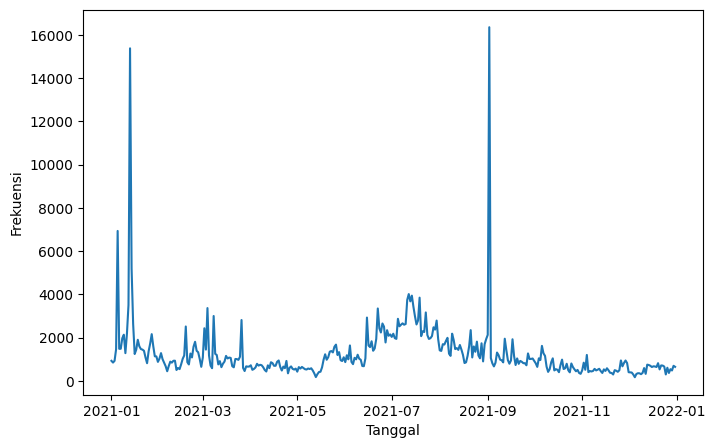

,date,count
0,2021-09-02,16360
1,2021-01-13,15383
2,2021-01-05,6932
3,2021-01-14,5197
4,2021-07-12,4011


In [7]:
tweet_freq = data["date"].dt.floor("d").value_counts().rename_axis("date").reset_index(name="count")
plt.figure(figsize=(8, 5))
sns.lineplot(x="date", y="count", data=tweet_freq)
plt.xlabel("Tanggal")
plt.ylabel("Frekuensi")
plt.show()

tweet_freq.sort_values("count", ascending=False).head(5)

In [8]:
STEMMER = StemmerFactory().create_stemmer()


def preprocessing(text):
    text = text.lower()
    text = re.sub(r"\s+", " ", text, flags=re.UNICODE)  # remove whitespace
    text = emoji_to_words(text)  # remove emoji
    text = unicodedata.normalize("NFD", text).encode("ascii", "ignore").decode("ascii")
    text = remove_html(text)  # remove html tags
    text = remove_url(text)  # remove url
    text = replace_word_elongation(text)
    text = replace_slang(text)  # replace slang words
    # text = remove_stopwords(text)
    text = text.translate(str.maketrans("", "", string.digits))  # remove numbers
    text = text.translate(
        str.maketrans(string.punctuation, " " * len(string.punctuation))
    )  # remove punctuation
    text = " ".join(text.split())
    text = STEMMER.stem(text)
    return " ".join(text.split())

data.drop_duplicates("content", inplace=True)

# run app 30 min
# data["cleaned"] = [preprocessing(x) for x in tqdm(data["content"].values)]

with open(os.path.join("..", "data", "cleaned-text.txt")) as reader:
    data["cleaned"] = reader.read().split("\n")[:-1]

data.drop_duplicates("cleaned", inplace=True)  # drop duplicates

In [9]:
import onnxruntime as ort

In [10]:
session = ort.InferenceSession("output/model.ort")
pred = [session.run(None, {"words": [[x]]}) for x in tqdm(data["cleaned"].values)]

  0%|          | 0/324834 [00:00<?, ?it/s]

In [11]:
data["prediksi"] = [x[0][0] for x in pred]
data.head()

,date,url,user,content,likes,retweet,reply,engagement,cleaned,prediksi
0,2021-01-31 23:56:43,https://twitter.com/Sistyriii/status/135602867...,Sistyriii,"""Bentar deh, dlu kan aku di vaksin campak smaa...",NaN,NaN,NaN,0.0,bentar deh dulu kan aku di vaksin campak sama ...,1
1,2021-01-31 23:55:07,https://twitter.com/Sistyriii/status/135602826...,Sistyriii,"Kemarin bokap bilang \n""Katanya wakil walikota...",NaN,NaN,NaN,0.0,kemarin bokap bilang kata wakil walikota depok...,5
2,2021-01-31 23:55:04,https://twitter.com/AhmadNorMaulana/status/135...,AhmadNorMaulana,Dokter Sebut Vaksin COVID-19 Aman Meski Ada Ef...,0.0,0.0,0.0,0.0,dokter sebut vaksin covid aman meski ada efek ...,0
3,2021-01-31 23:45:08,https://twitter.com/DIMASBA20908752/status/135...,DIMASBA20908752,@DonAdam68 Apa tidak pernah memikirkan nasip r...,1.0,0.0,0.0,1.0,donadam apa tidak pernah pikir nasip rakyat ya...,0
4,2021-01-31 23:38:40,https://twitter.com/datukhensem/status/1356024...,datukhensem,Salah vaksin hantar kat Myanmar ni. Orang nak ...,4.0,4.0,0.0,8.0,salah vaksin hantar kat myanmar nih orang nak ...,0


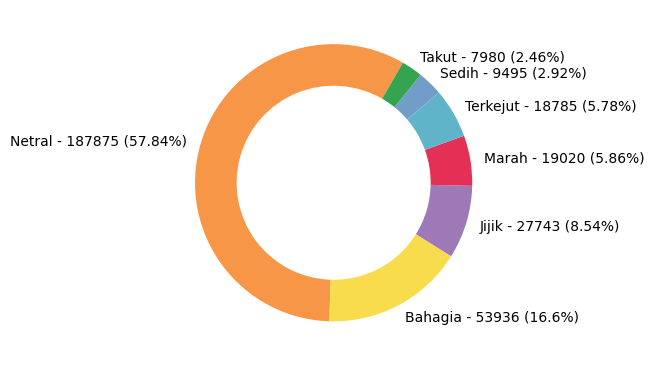

In [12]:
pie_data = data["prediksi"].value_counts()
label_mapper = ["netral", "terkejut", "bahagia", "marah", "takut", "jijik", "sedih"]
color_mapper = ["#F79647", "#5FB4C9", "#F9DC4B", "#E43055", "#34A450", "#9E79B7", "#729DC8"]
labels = [
    (
        f"{label_mapper[pie_data.index[i]].title()} - {pie_data.values[i]}"
        + f" ({round(pie_data.values[i] / sum(pie_data.values) * 100, 2)}%)"
    )
    for i in range(len(pie_data.values))
]

plt.figure(figsize=(4.5, 4.5))
plt.pie(
    pie_data.values,
    labels=labels,
    colors=[color_mapper[x] for x in pie_data.index],
    wedgeprops={"width": 0.3},
    startangle=60,
)

plt.show()

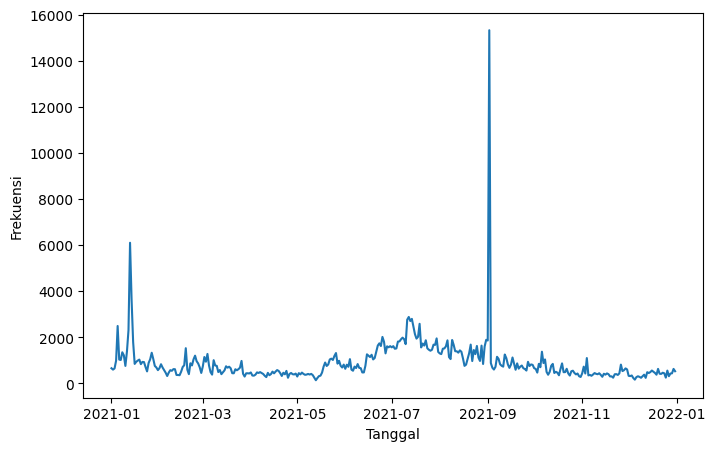

,date,count
0,2021-09-02,15320
1,2021-01-13,6094
2,2021-01-14,3620
3,2021-07-12,2873
4,2021-07-14,2790


In [13]:
tweet_freq = data["date"].dt.floor("d").value_counts().rename_axis("date").reset_index(name="count")
plt.figure(figsize=(8, 5))
sns.lineplot(x="date", y="count", data=tweet_freq)
plt.xlabel("Tanggal")
plt.ylabel("Frekuensi")
plt.show()

tweet_freq.sort_values("count", ascending=False).head(5)

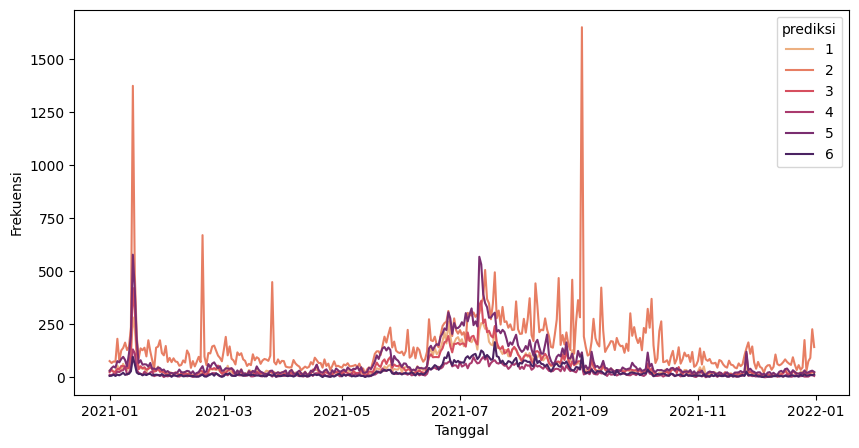

In [14]:
line_data = data.groupby([data["date"].dt.floor('d'), "prediksi"]).size().reset_index(name='count')
plt.figure(figsize=(10, 5))
sns.lineplot(x="date", y="count", hue="prediksi", data=line_data[line_data["prediksi"] != 0], palette="flare")
plt.xlabel("Tanggal")
plt.ylabel("Frekuensi")
plt.show()

In [108]:
from indoNLP.preprocessing import STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer

In [118]:
vectorizer = CountVectorizer(ngram_range=(1, 2), 
                             stop_words=list(STOPWORDS) + ["vaksin", "covid", "orang", "wajah", "kena", "sih", "nih", 
                                                           "kalo", "deh", "gue"], 
                             max_features=5000)
trans = vectorizer.fit_transform(data["cleaned"])
trans

/home/hyuto/skripsi/.venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kurangnya', 'kw', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya', 'wk'] not in stop_words.
  warnings.warn(


<324834x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 3607269 stored elements in Compressed Sparse Row format>

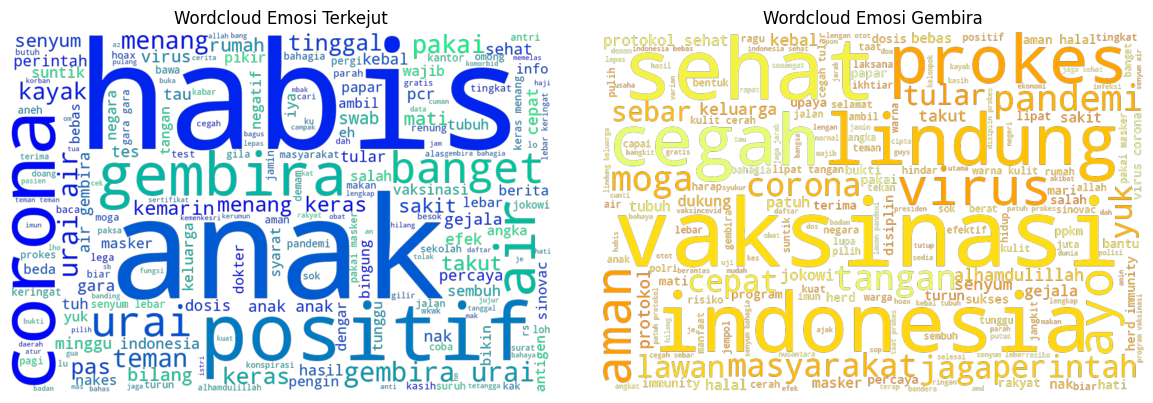

In [119]:
def get_wc(filter_label, cmap="viridis"):
    wc = WordCloud(
        mode="RGBA",
        background_color=None,
        width=1200,
        height=800,
        random_state=2022,
        colormap=cmap,
        stopwords=list(STOPWORDS) + ["vaksin"]
    )
    frek = np.asarray(trans[data["prediksi"] == filter_label].sum(axis=0)).flatten()
    vocab = dict(zip(dict(sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1])).keys(), frek))
    wc.fit_words(vocab)
    # wc.generate("\n".join(data[data["prediksi"] == 1]["cleaned"]))
    return wc

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.imshow(get_wc(1, "winter_r"), interpolation="bilinear")
ax1.set_title("Wordcloud Emosi Terkejut")
ax1.axis("off")
ax2.imshow(get_wc(2, "Wistia_r"), interpolation="bilinear")
ax2.set_title("Wordcloud Emosi Gembira")
ax2.axis("off")
plt.tight_layout()
plt.show()

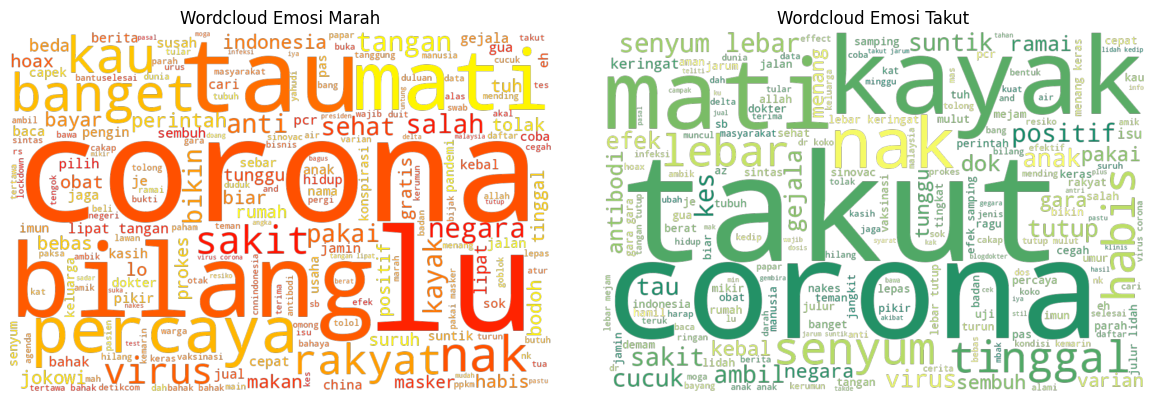

In [120]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.imshow(get_wc(3, "autumn_r"), interpolation="bilinear")
ax1.set_title("Wordcloud Emosi Marah")
ax1.axis("off")
ax2.imshow(get_wc(4, "summer_r"), interpolation="bilinear")
ax2.set_title("Wordcloud Emosi Takut")
ax2.axis("off")
plt.tight_layout()
plt.show()

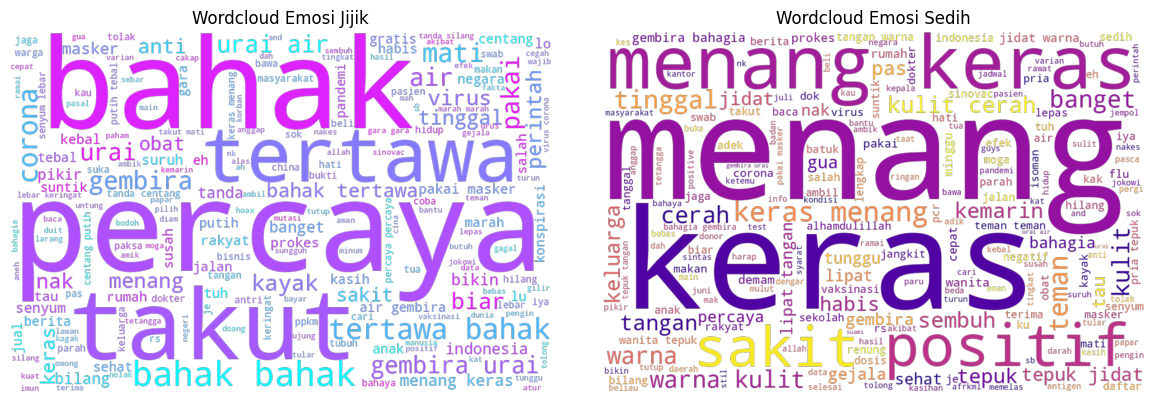

In [121]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.imshow(get_wc(5, "cool"), interpolation="bilinear")
ax1.set_title("Wordcloud Emosi Jijik")
ax1.axis("off")
ax2.imshow(get_wc(6, "plasma_r"), interpolation="bilinear")
ax2.set_title("Wordcloud Emosi Sedih")
ax2.axis("off")
plt.tight_layout()
plt.show()

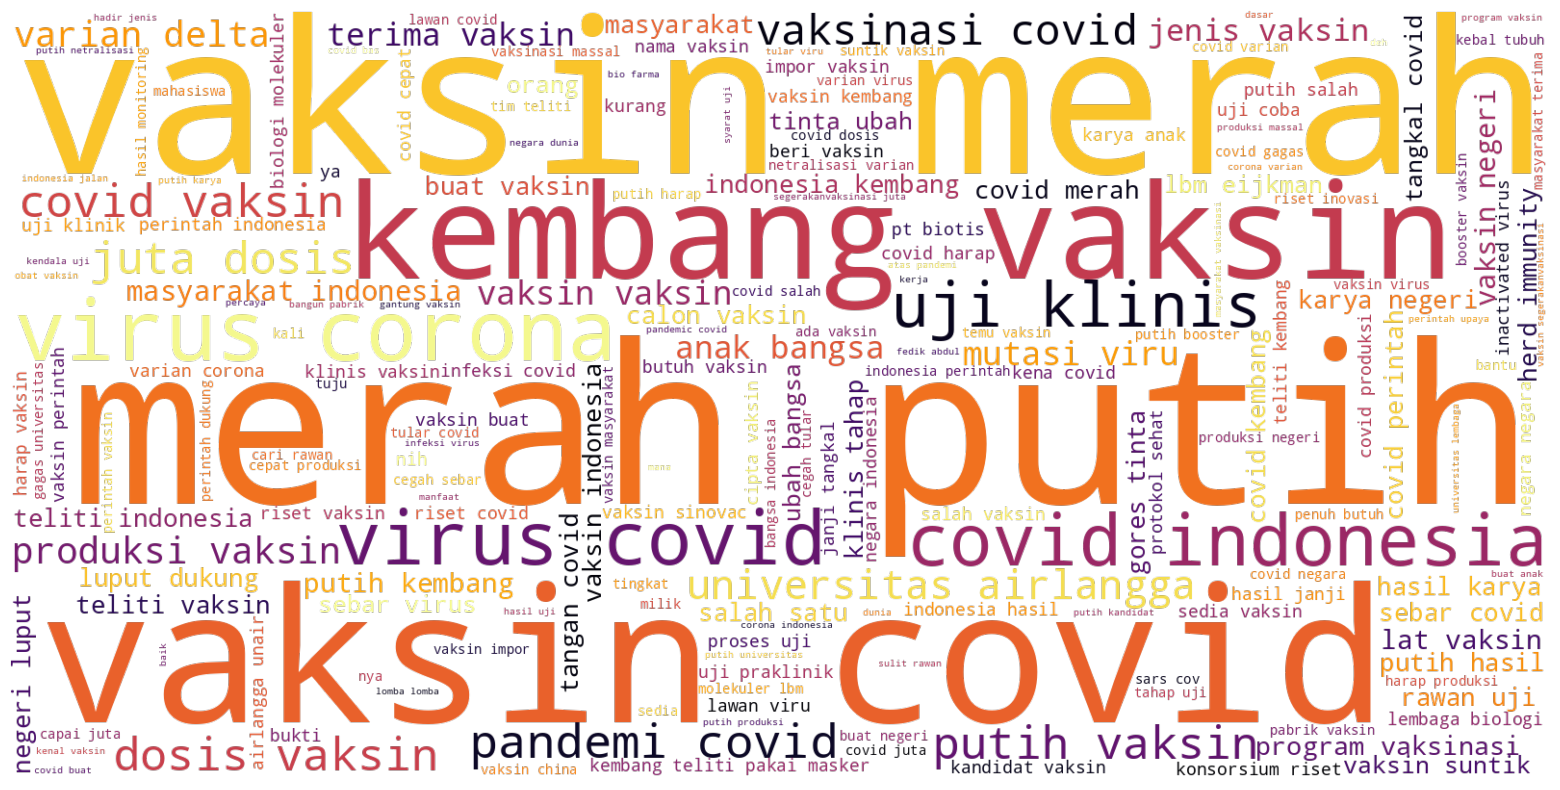

In [34]:
wordcloud = WordCloud(
    mode="RGBA",
    background_color=None,
    width=1600,
    height=800,
    random_state=2022,
    colormap="inferno",
)
wordcloud.generate(" ".join(data.query("'2021-09-01' < date < '2021-09-03'")["cleaned"].tolist()))

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()